https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

MLE tries to answer the question: Which are the best parameters/coefficients for my model?

Bayes Theorem: P(B|D) = (P(B) * P(D|B)) / P(D)

Probability of the belief, given the data = probability of belief * probability of the data, given the belief / Probability of Evidence

Posterior = Prior * Likelihood / Evidence

For purposes of Maximum Likelihood Estimation, we can ignore the `prior` and `evidence`.

We want to find the probability of some specific coefficients, given the results we've seen. That's equivalent to the probability of the results, given a certain set of coefficients (?)

In [3]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats

import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [4]:
N = 100
x = np.linspace(0, 20, N)
# e is the error
# - normally distributed around 0...one of the assumptions with
# using MLE
e = np.random.normal(loc=0.0, scale=5.0, size=N)
y = 3*x + e

df = pd.DataFrame({'y': y, 'x': x})
df['constant'] = 1

/Users/joshr/Envs/nba-model/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


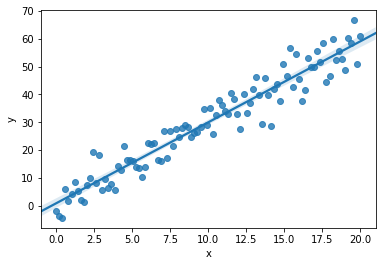

In [5]:
sns.regplot(df.x, df.y);

In [6]:
# split features and target
X = df[['constant', 'x']]

# fit model and summarize
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1197.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):           9.68e-57
Time:                        18:01:50   Log-Likelihood:                -299.95
No. Observations:                 100   AIC:                             603.9
Df Residuals:                      98   BIC:                             609.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.8418      0.974      0.864      0.390      -1.091       2.775
x              2.9116      0.084     34.602      0.000       2.745       3.079
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.340
Skew:                          -0.127   Prob(JB):                        0.844
Kurtosis:                       2.870   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, the training data is the constant and x. 

In the SSEM case, the training data to fit would be the rating for the Home Team, the rating for the Away Team, and the Home Field Advantage constant.

In [16]:
def MLERegression(params):
    # params are guesses at our parameters
    # beta is the coefficient
    intercept, beta, sd = params[0], params[1], params[2]
    
    # yhat is our prediction, given some data.
    yhat = intercept + beta * x
    
    # ??? What is log likelihood?
    negLL = -1 * np.sum(stats.norm.logpdf(y, loc=yhat, scale=sd))
    return negLL

guess = np.array([5, 5, 2])
results = minimize(MLERegression, guess, method='Nelder-Mead', options={'disp': True})


Optimization terminated successfully.
         Current function value: 299.949211
         Iterations: 100
         Function evaluations: 183


In [12]:
results

 final_simplex: (array([[0.84168833, 2.91161691, 4.85764776],
       [0.84163992, 2.91162373, 4.85762173],
       [0.84161666, 2.91162793, 4.8576292 ],
       [0.8416008 , 2.91162543, 4.85764546]]), array([299.94921052, 299.94921052, 299.94921052, 299.94921053]))
           fun: 299.94921051787594
       message: 'Optimization terminated successfully.'
          nfev: 183
           nit: 100
        status: 0
       success: True
             x: array([0.84168833, 2.91161691, 4.85764776])

In [14]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf, 4)

,coef
constant,0.8417
x,2.9116
sigma,4.8576


## Summary

Four major steps in applying MLE:
1. Define the likelihood & ensure you're using the right distribution.
2. Take the natural log and reduce the product function to a sum function.
    - What does this mean? 
3. Maximize (or minimize the negative) of the objective function.
4. Verify that uniform priors are a safe assumption.  
    - A uniform prior means that all possible values are equally likely _a priori_

Still a lot of uncertainty with the above. 
- What is log likelihood? Why are we minimizing the negative of that rather than minimizing the error? 
- What even is Maximum Likelihood Estimation? What is it doing for us that a linear regression isn't?

----------

Read 
https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1 for more background.

What are parameters? The parts of a model that can be changed to produce a model of better quality. Parameters define the blueprint for the model.

"It is only when specific values are chosen for the parameters that we get an instantiation for the model that describes a given phenomenon"

"MLE is a method that determines values for the parameters of a model. The parameter values are found such that they maximise the likelihood that the process described by the model produced the data that were actually observed."
* This is why we want the _maximum_

We first have to decide which model we think best describes the process of generating the data. 

(In SSEM, this is the logistic function)

Let's say we have 10 data points that represent the amount of time a student spent on an exam question.

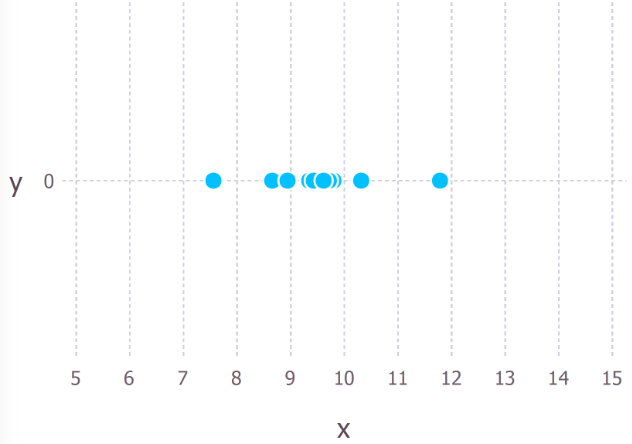

And let's say we think a Gaussian distribution describes this data best. A Gaussian distribution has 2 parameters: the mean and standard deviation. We want to know: which combination of these parameters is most likely responsible for creating the data points we observed? 

MLE will find those parameter values.

We speak of this as maximizing a likelihood rather than minimizing an error.

__Calculating MLE Estimates__

Another example: 
- we have 3 data points - 9, 9.5, 11. 
- we think these data were generated by a Gaussian process.
- How do we calculate a likelihood estimate for a set of parameter values (mean and standard dev)?

More specifically, the maximum likelihood estimate is the `total probability of observing all the data` -- this means we are interested in the joint probability! 

Since the events should be independent (not necessarily the case in sports, if team A might be more likely to win game 2 if they lost game 1), then we can just multiply the probabilities together. This is why we want a product!

The probability density of observing a single data point x, that is generated from a Gaussian distribution is given by:

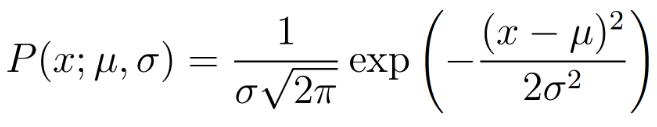

and the total (joint) probability density of observing the 3 data points is given by the product of the above, for each data point:

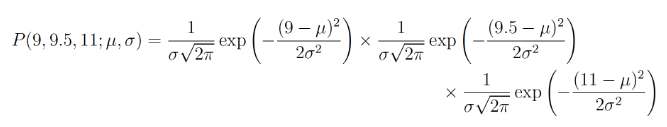

This produces its own probability distribution. We want the values of mean and standard deviation that produce the maximum of that value.

To do that, compute the derivative and set it equal to 0 (calculus).

__The Log Likelihood__

Used as a convenience when doing computation. The above expression is difficult to differentiate, so we instead just compute the natural logarithm.

Since ln is monotonically increasing, the maximum value of log probability occurs at the same point as in the original probability function. So this is pretty much a substitute and computing the first derivative of this will give us the same value.

__Maximum Likelihood vs Maximum Probability?__

- This is actually described in the post above. Probability (I think this means posterior) is the probability of a belief, given some data. The likelihood is the probability of the data, given a belief.
- The two are the same (proportional) by Bayes Theorem. 
- In our problem, we want to know what the probability of observing data is given our belief in a certain set of parameters. Hence, we use likelihood. Makes sense! 

__When is MLE the same as Least Squares Minimisation?__

This gets mathy, but basically when the model is assumed to be Gaussian, MLE = least squares method. 

However, if our model is logistic or something else, this assumption is not true.

## Other Background

Just bite the bullet and read up on the Squared2020 Article [here](https://squared2020.com/2017/11/09/bradley-terry-rankings-introduction-to-logistic-regression/).

> We focus on a probabilistic framework for measuring pairwise comparisons of teams through the use of home-away indicators and win-loss results.

> Focuses on pairwise matchups between teams, dependent on location -- the result is whether a particular team came away with a victory.

^^ Yes, this is our usecase.

> Each row is a game.

> Home team is delineated as a +1. Away team as a -1.

Interesting, so one row of data looks like: 

__(0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1)__

the -1 is the away team, the +1 is the home team, and the last 1 is an intercept.

> Persisting with usual least-squares method will lead us to predicting __real values__ instead of __win-loss__ which is what we are ultimately after. To account for this, enter __logistic regression__.

> Logistic Regression is a methodology for identifying a regression model for __binary response data__ (who won and who lost). 

Idea: Just have home tema have a +1 and away team have a -1. And add in the HFA into the formula as before.

#### Machine Learning Mastery

[https://machinelearningmastery.com/logistic-regression-for-machine-learning/](Here): Helps to explain that Logistic Regression is predicting the probability of the home team winning. 

The probability is expressed in the following way: 

`ln(odds) = b0 + b1 * X`

`odds = e^(b0 + b1 * X)`

So logistic regression assumes a linear relationship between the parameters and the natural logarithm of the odds of the default class.

#### StackOverflow post

https://stats.stackexchange.com/questions/440242/statsmodels-logistic-regression-adding-intercept helps to clarify the role of the intercept in a logistic regression equation.